# MobileNet AutoEncoder for Monocular Depth Estimation

In [1]:
!nvidia-smi

Wed May  5 23:22:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0  On |                  N/A |
| 31%   50C    P8    20W / 250W |    337MiB / 11175MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3080    Off  | 00000000:0A:00.0 Off |                  N/A |
| 53%   

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D, Input, SeparableConv2D, Lambda, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import backend as K

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [30]:
def upBlock(x, skip, filters, kernel_s=(5,5),
               padding_='same', strides_= 1,
               activation_='relu', name='upblock'):
    padding = 4 // 2  # kernelsize - 1// 2
    conv1 = SeparableConv2D(filters, kernel_size=kernel_s,
                          padding='same', strides=strides_,
                          kernel_initializer='he_uniform',
                          activation=activation_, name='{}_conv'.format(name))(x)
    x = UpSampling2D((2,2), interpolation='nearest')(conv1)
    if skip is not None:
        x = x + skip
    return x

def mobilenet_model(input_shape):
    inputs = Input(input_shape)
    
    '''Load pre-trained MobileNet'''
    mobilenet = MobileNet(include_top=False, weights='imagenet', input_tensor=inputs)
    
    '''Decoder'''
    mobilenet_final_output_shape = mobilenet.layers[-1].output.shape
    decode_filters = int(mobilenet_final_output_shape[-1])
    decoder = Conv2D(filters=decode_filters, kernel_size=1, padding='same', input_shape=mobilenet_final_output_shape, name='decoder_conv_1')(mobilenet.output)
    
    decoder = upBlock(decoder, None, int(decode_filters / 2), name='uplock_1')
    decoder = upBlock(decoder, mobilenet.layers[30].output, int(decode_filters / 4), name='uplock_2')
    decoder = upBlock(decoder, mobilenet.layers[17].output, int(decode_filters / 8), name='uplock_3')
    decoder = upBlock(decoder, mobilenet.layers[7].output, int(decode_filters / 16), name='uplock_4')
    decoder = upBlock(decoder, None, int(decode_filters/32), name='upblock_5')
#     decoder = upBlockPointWise(decoder, None, int(decode_filters/32), name='upblock_6')
    
    # conv_dw_1 x1 4, conv_dw_3 x2, conv_dw_5 x3
    
    outputs = Conv2D(1, kernel_size=(1,1), padding='same', name='decoder_final_conv')(decoder)
    outputs = Activation(activation='relu')(outputs)
    model = keras.models.Model(inputs, outputs)
    return model

In [31]:
model = mobilenet_model((128, 128, 3))

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 64, 64, 32)   0           conv1_bn[0][0]                   
______________________________________________________________________________________________

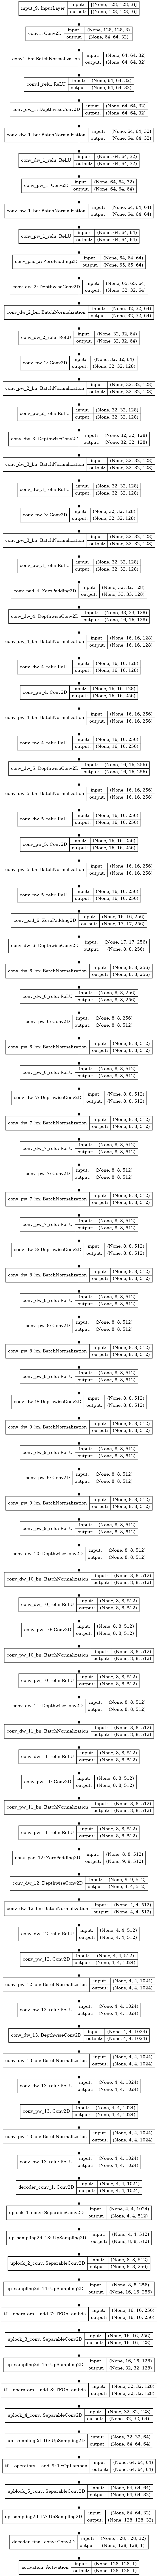

In [33]:
keras.utils.plot_model(model, show_shapes=True, to_file='mobilenet-autoecoder.png')

In [34]:
# finish this later on...
import tensorflow.keras as keras
from skimage.transform import resize
from PIL import Image
import numpy as np
import cv2
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, batch_size = 8, image_size = 128):
    self.batch_size = batch_size
    self.image_size = image_size
    self.max_depth = 1000.0
    
  def load(self, rgb_file, depth_file):
    image = cv2.imread(rgb_file)
    image = cv2.resize(image, (self.image_size, self.image_size)) # resize...
    depth = cv2.imread(depth_file, -1)
    depth = cv2.resize(depth, (self.image_size, self.image_size)) 
#     print(self.max_depth)
    image_normalized = image/np.max(image)
    depth_normalized = depth/np.max(depth) # double check the depth images!
    return image_normalized, depth_normalized

  def load_all(self, rgb_files, depth_files):
        images = []
        depths = []
        for i in range(len(rgb_files)):
            img, dpth = self.load(rgb_files[i], depth_files[i])
            images.append(img)
            depths.append(dpth)
        return np.array(images), np.array(depths)

In [35]:
# Get file names
rgb_images = os.listdir('train-data/rgb/')
rgb_images.sort()
rgb_images = [str('train-data/rgb/') + file for file in rgb_images]
depth_images = os.listdir('train-data/depth/')
depth_images.sort()
depth_images = [str('train-data/depth/') + file for file in depth_images]

test_size = 250
rgb_images_test = rgb_images[:test_size]
depth_images_test = depth_images[:test_size]

rgb_images_train = rgb_images[test_size:]
depth_images_train = depth_images[test_size:]

# Load data:

load_data = DataGenerator()

X_train, y_train = load_data.load_all(rgb_files=rgb_images_train, 
                                      depth_files=depth_images_train)

X_test, y_test = load_data.load_all(rgb_files=rgb_images_test, 
                                  depth_files=depth_images_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1359, 128, 128, 3) (1359, 128, 128)
(250, 128, 128, 3) (250, 128, 128)


In [36]:
def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    y_true = tf.expand_dims(y_true, -1)
    y_pred = tf.expand_dims(y_pred, -1)
    
    # Point-wise depth
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

In [37]:
model.compile(optimizer='adam', loss=depth_loss_function)

In [38]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
model.fit(X_train, y_train, batch_size=16, epochs=200, validation_split=0.2, verbose=1)

Epoch 1/200
68/68 [==============================] - 131s 973ms/step - loss: 0.2220 - val_loss: 0.2203
Epoch 2/200
68/68 [==============================] - 2s 36ms/step - loss: 0.2017 - val_loss: 0.2203
Epoch 3/200
68/68 [==============================] - 2s 36ms/step - loss: 0.2048 - val_loss: 0.2203
Epoch 4/200
68/68 [==============================] - 2s 37ms/step - loss: 0.2045 - val_loss: 0.2203
Epoch 5/200
68/68 [==============================] - 2s 36ms/step - loss: 0.2039 - val_loss: 0.2203
Epoch 6/200
68/68 [==============================] - 2s 37ms/step - loss: 0.2036 - val_loss: 0.2203
Epoch 7/200
68/68 [==============================] - 3s 37ms/step - loss: 0.2046 - val_loss: 0.2203
Epoch 8/200
68/68 [==============================] - 2s 37ms/step - loss: 0.2016 - val_loss: 0.2203
Epoch 9/200
68/68 [==============================] - 3s 38ms/step - loss: 0.2029 - val_loss: 0.2203
Epoch 10/200
68/68 [==============================] - 3s 37ms/step - loss: 0.2012 - val_loss: 0.2

In [39]:
preds = model.predict(X_test)

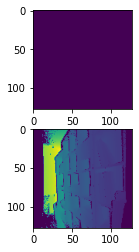

In [40]:
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(2,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(2,1,2)
plt.imshow(y_test[0]*255)

In [28]:
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

17227776/17225924 [==============================] - 1s 0us/step


In [9]:
layer_names = [layer.name for layer in mobilenet.layers]

In [12]:
layer_names.index('conv_dw_1')

4

In [29]:
mobilenet.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32) 

In [8]:
for i in range(1,6):
    print(i)

1
2
3
4
5
